# Core Features: Import

In [2]:
# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.metrics.metric import Metric
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [3]:
from pyhessian.utils import *
from pyhessian import hessian, get_esd_plot, density_generate # ESD plot

In [4]:
from segmentationCRF import metrics
from segmentationCRF.models import UNet
from segmentationCRF.data_utils import get_datset, get_default_transforms
from segmentationCRF.utils import check_make_dir
from segmentationCRF import test
from segmentationCRF.crfseg import CRF

In [19]:
# libraries
import copy
import sys
import os
from typing import List
import time
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchinfo import summary
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

## 1. Preliminary: Define Parameters

In [5]:
# Hyper-parameters
data_path = "/global/cfs/cdirs/m636/geshi/data/"
input_size = 224
batch_size=32
n_workers = 0
classes = ('foreground', 'background', 'border')
n_classes = len(classes)

data_transform, target_transform = get_default_transforms('oxford', input_size, n_classes, noise_level=0)

In [6]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [32, 64, 128, 256, 512], 
    'out_channels': [32, 64, 128, 256, 512],
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1024, 512, 256, 128],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [512, 256, 128, 64, 32],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': n_classes,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# contour plot resolution
STEPS = 20
NORM = 'layer'
DIST = 0.01
MODEL_DIR = '/global/cfs/cdirs/m636/geshi/exp/Oxford/crf/CrossEntropy/0_seed_9999'
seed = (int)(MODEL_DIR.split('/')[-1].split('_')[-1])

In [10]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [11]:
dataset_parameters = {
    'data_path': data_path,
    'split': 'trainval',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

val_dataset_parameters = {
    'data_path': data_path,
    'split': 'test',
    'data_transform': data_transform,
    'target_transform': target_transform,
    'download': True,
}

dataset = get_datset('oxford', dataset_parameters)
val_dataset = get_datset('oxford', val_dataset_parameters)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## 2. Model construction and evaluation

In [12]:
x = torch.rand(1, 3, input_size, input_size)
unet = UNet(downward_params, upward_params, output_params)
model = nn.Sequential(
    unet,
    CRF(n_spatial_dims=2)
)
out = model(x)
print('output shape', out.shape)

output shape torch.Size([1, 3, 224, 224])


In [13]:
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

In [14]:
model_name = 'iter30-11-17-2023-19:03:26.pt'

In [15]:
checkpoint = torch.load(os.path.join(MODEL_DIR, model_name), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
test(model, val_dataloader, n_classes, device)

Test : 100%|██████████| 115/115 [01:52<00:00,  1.02batch/s, accuracy=88.6]

Testing complete in 1m 53s, Test Acc: 88.58184440157399, Test Iou: 0.7418040093653446


(array([0.848312  , 0.85558897, 0.52151106]),
 {'test_acc': 88.58184440157399,
  'test_homogeneity': 0.028149881100388175,
  'test_frequency_weighted_IOU': 0.8007160772090659,
  'test_mean_IOU': 0.7418040093653446})

In [16]:
criterion = torch.nn.CrossEntropyLoss() # DiceLoss(True), IOULoss(softmax=True)
model_final = copy.deepcopy(model)

In [17]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. UNet-CRF 2D Loss Landscapes

### 3.1 PyHessian Directions and Spectrum

In [20]:
hessian_comp = hessian(model_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [21]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 489.8373


In [22]:
density_eigen, density_weight = hessian_comp.density()

In [23]:
density, grids = density_generate(density_eigen, density_weight)

/global/u2/g/geshi/loss-landscapes-segmentation/pyhessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/text.py:897: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


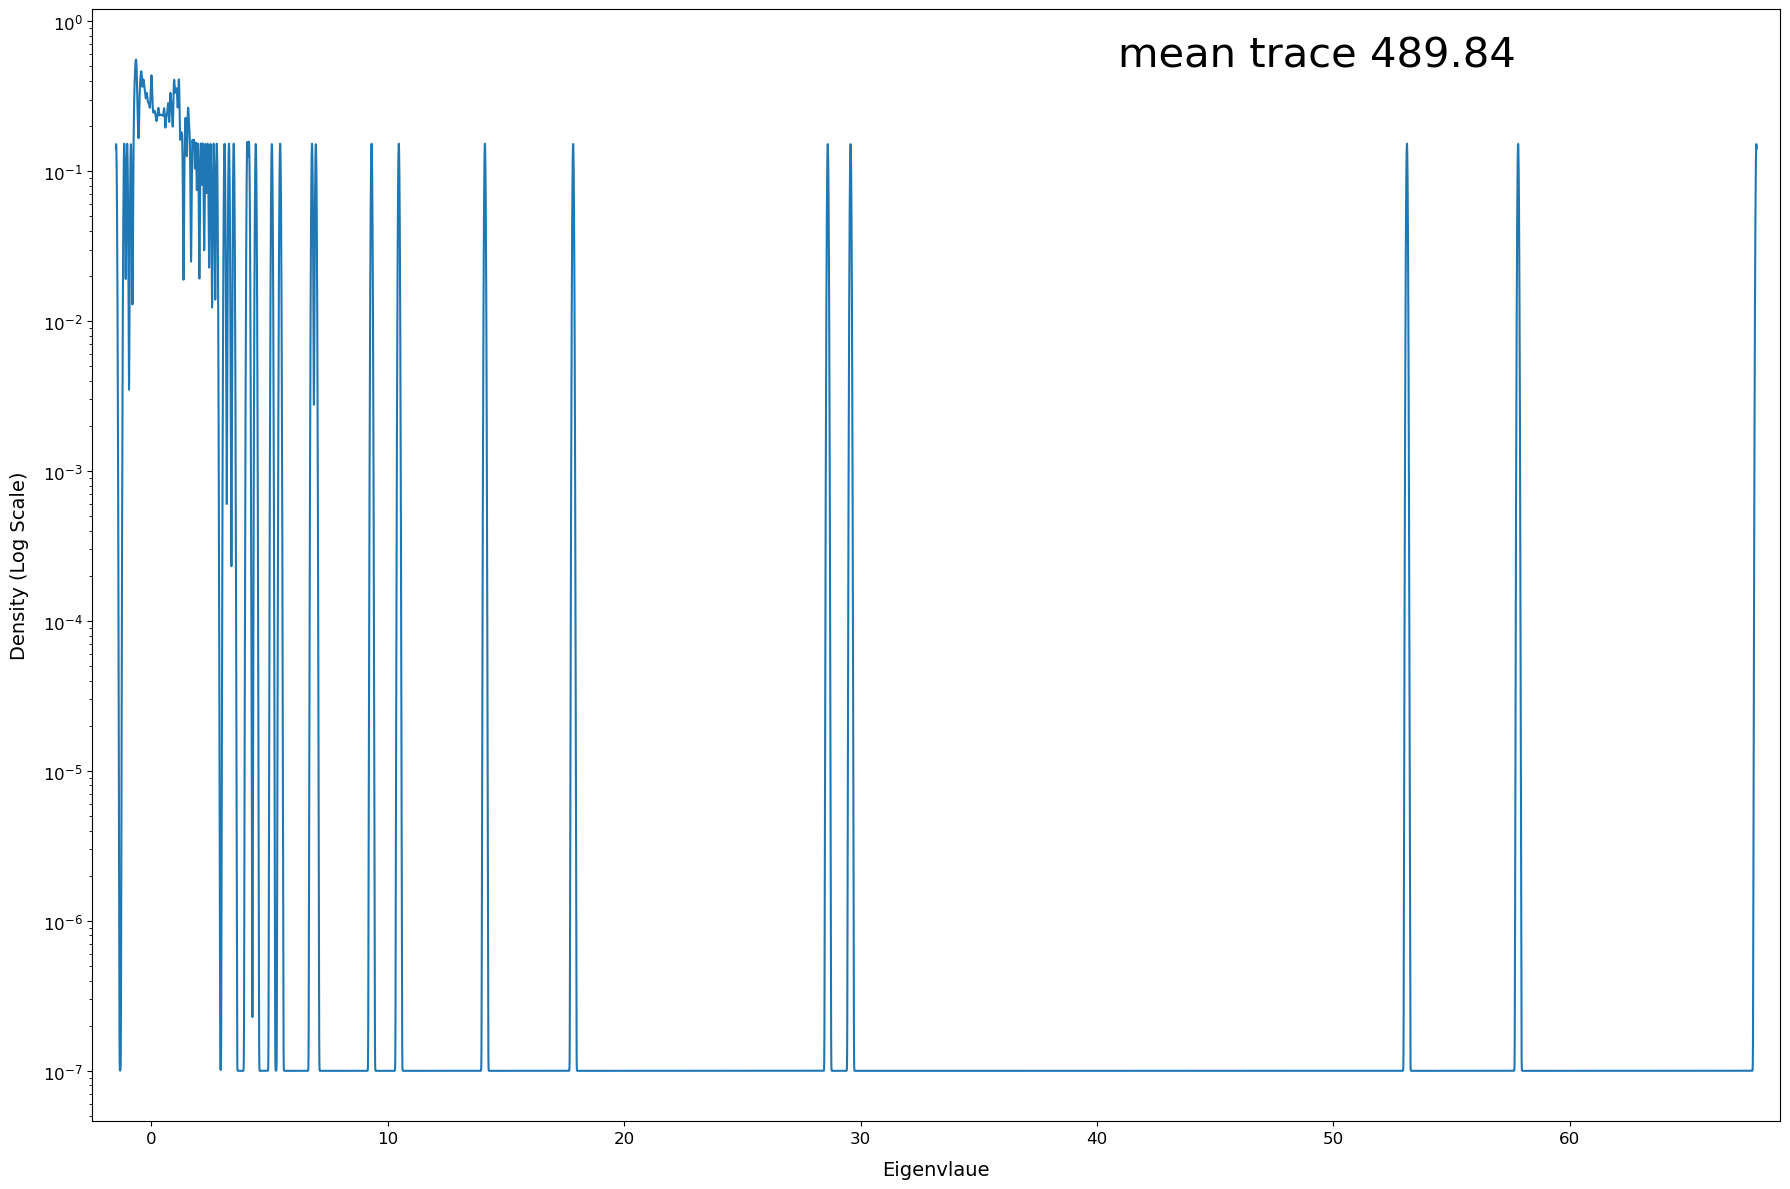

In [24]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 3.2. 2D Loss Landscape by PyHessian Directions

In [28]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll.stats_initializer()

In [29]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  46.55681824684143
compute time cost  44.842647552490234


In [30]:
# loss_data_fin = log_refined_loss(loss_data)
loss_data_fin = loss_data

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

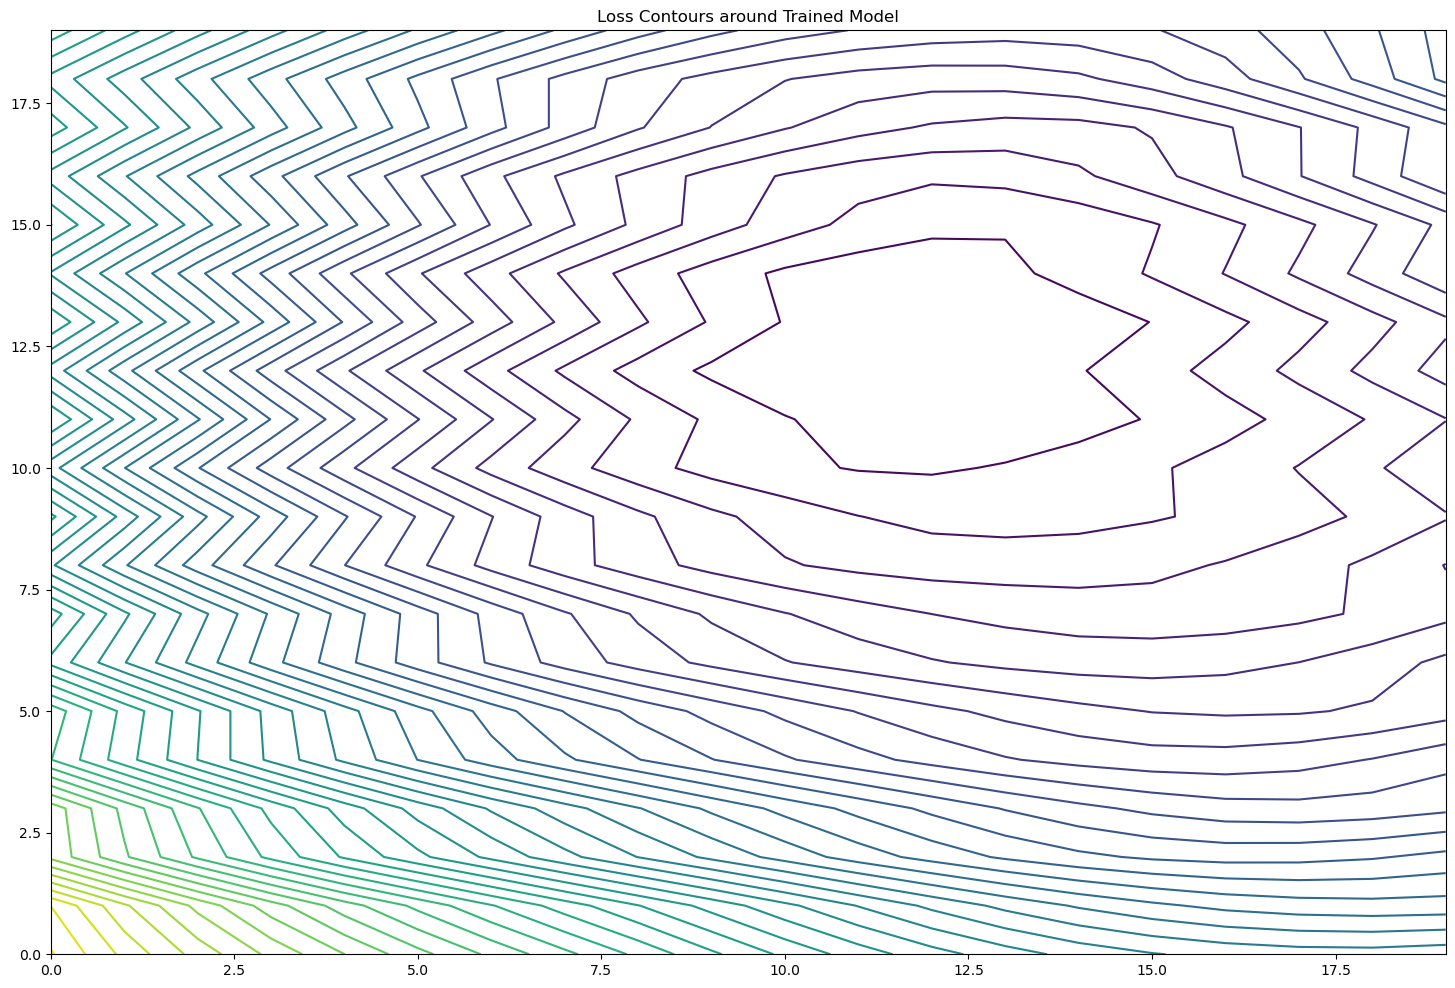

In [31]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

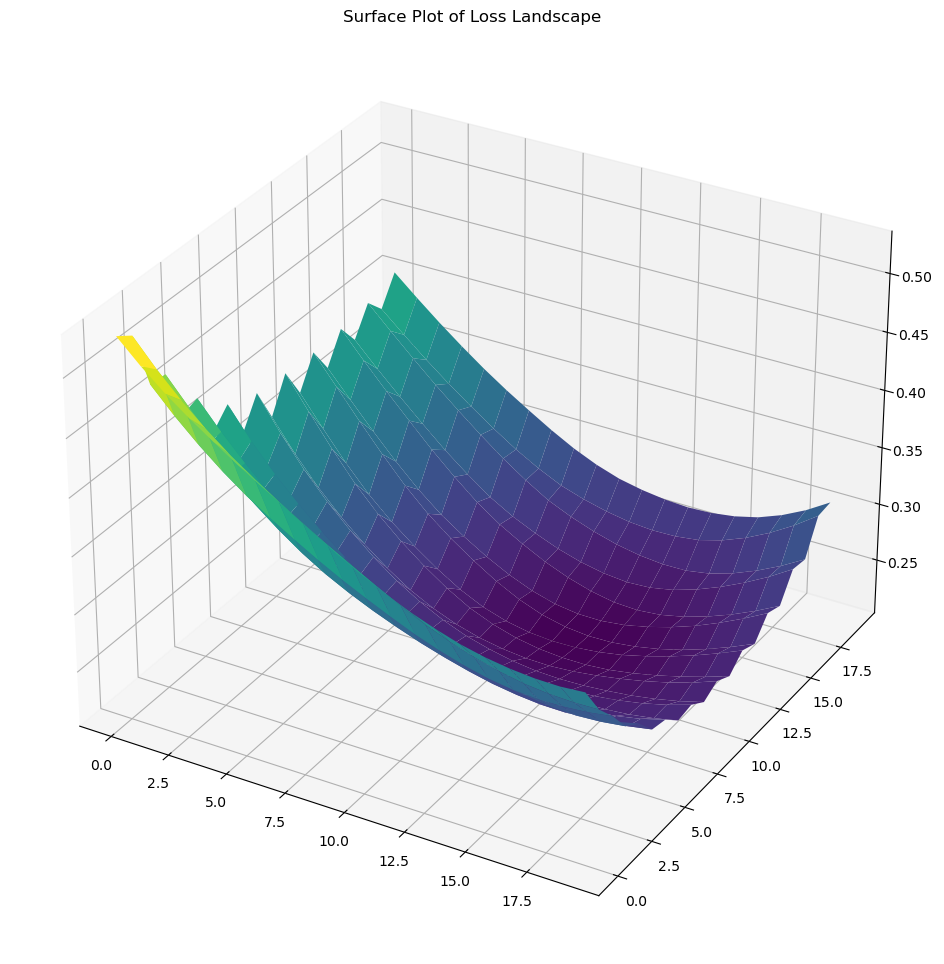

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [33]:
with open('pyhessian-unet-crf-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_fin)

In [34]:
unet_final = model_final[0]
crf_final = model_final[1]

## 4. UNet 2D Loss Landscapes

### 4.1 PyHessian Directions and Spectrum

In [35]:
hessian_comp = hessian(unet_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [36]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 355.8019


In [37]:
density_eigen, density_weight = hessian_comp.density()

In [38]:
density, grids = density_generate(density_eigen, density_weight)

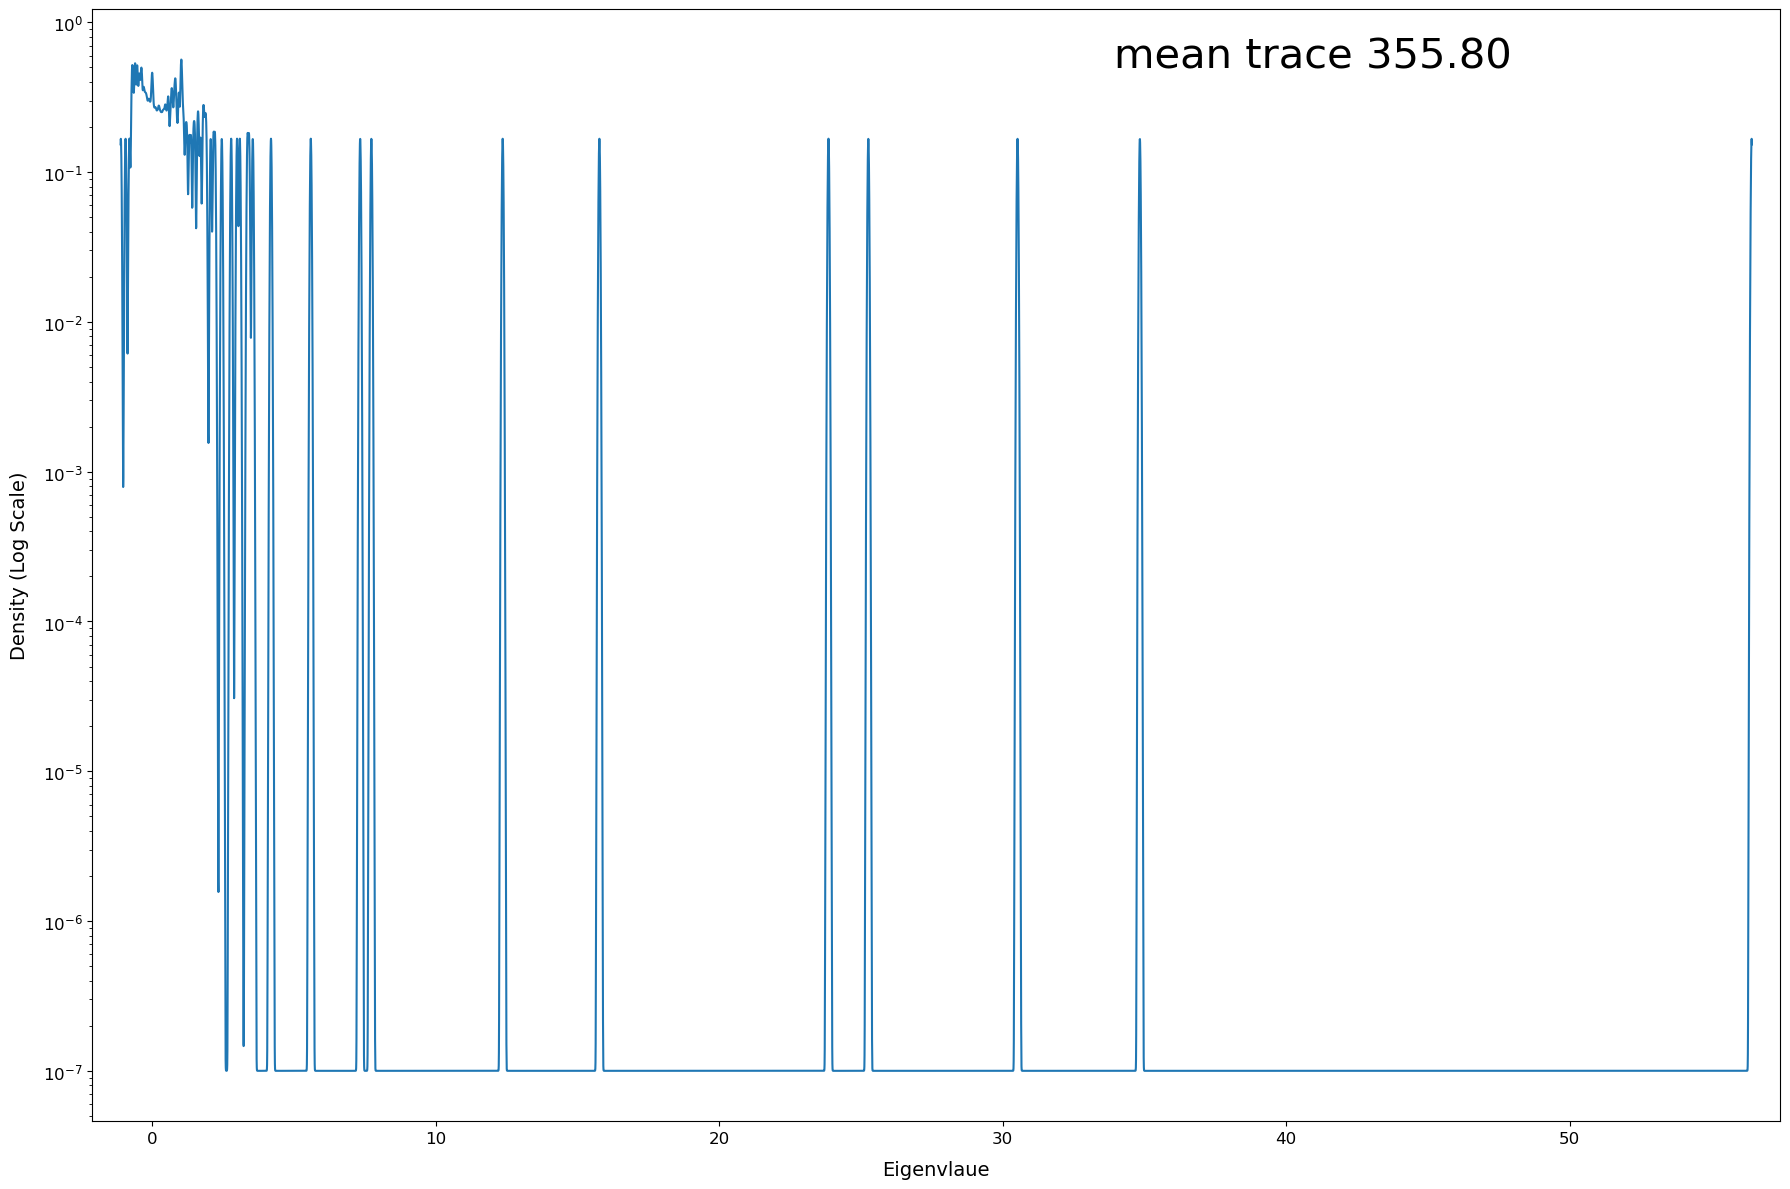

In [39]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 4.2. 2D Loss Landscape by PyHessian Directions

In [40]:
# compute loss data
pll_unet = loss_landscapes.PlanarLossLandscape(unet_final, STEPS, deepcopy_model=True)
pll_unet.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_unet.stats_initializer()

In [41]:
# single batch loss landscape
since = time.time()
pll_unet.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet = pll_unet.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  16.666690349578857
compute time cost  14.515784740447998


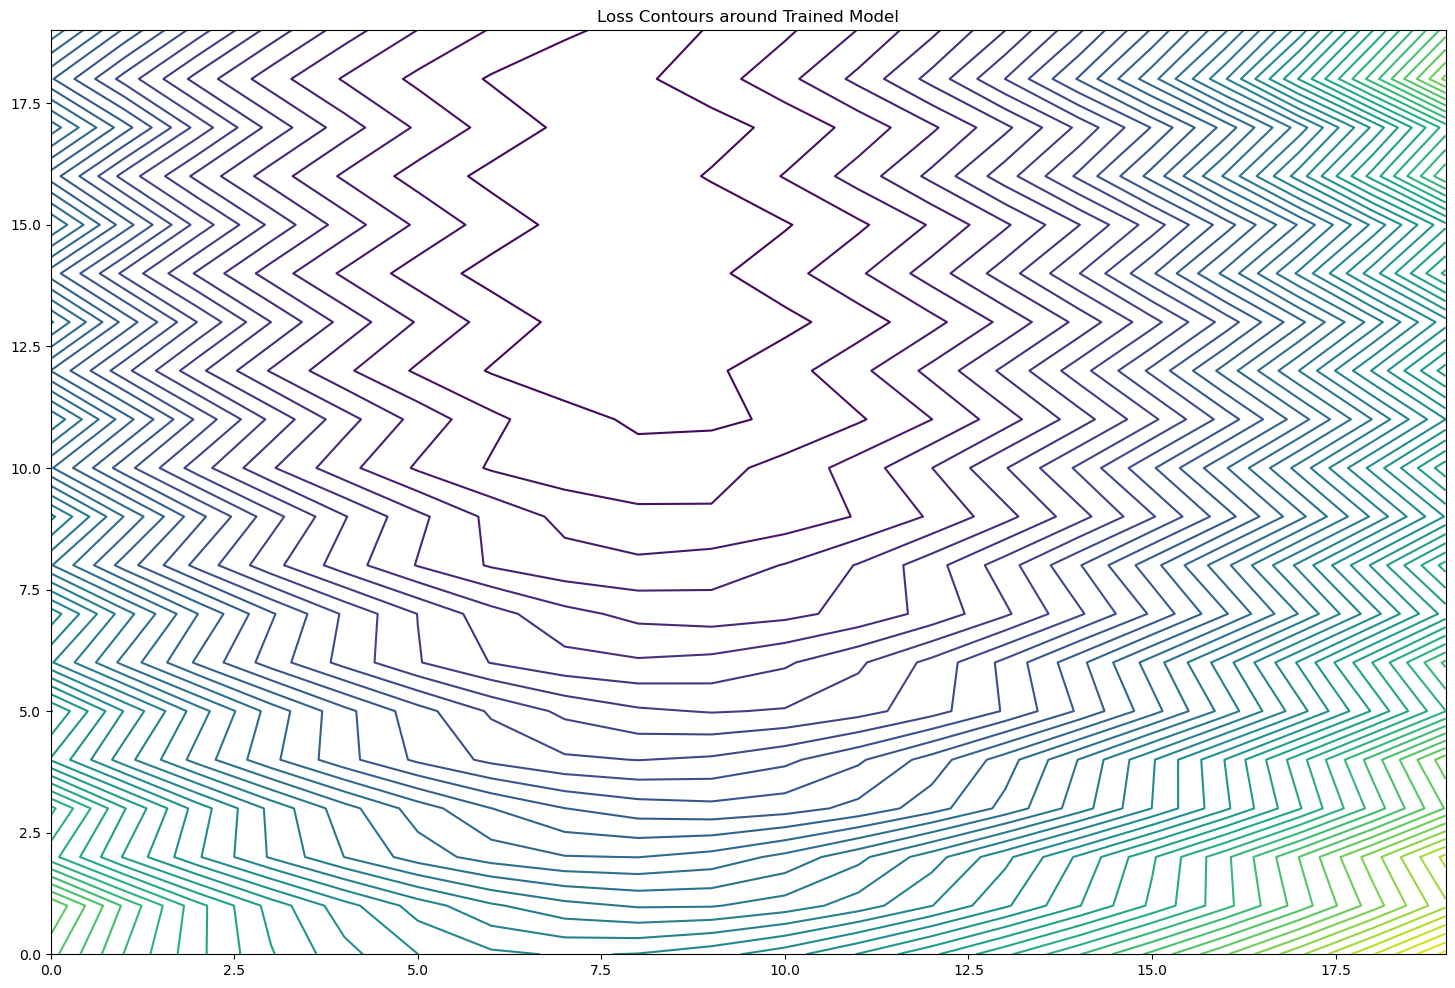

In [42]:
plt.contour(loss_data_unet, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

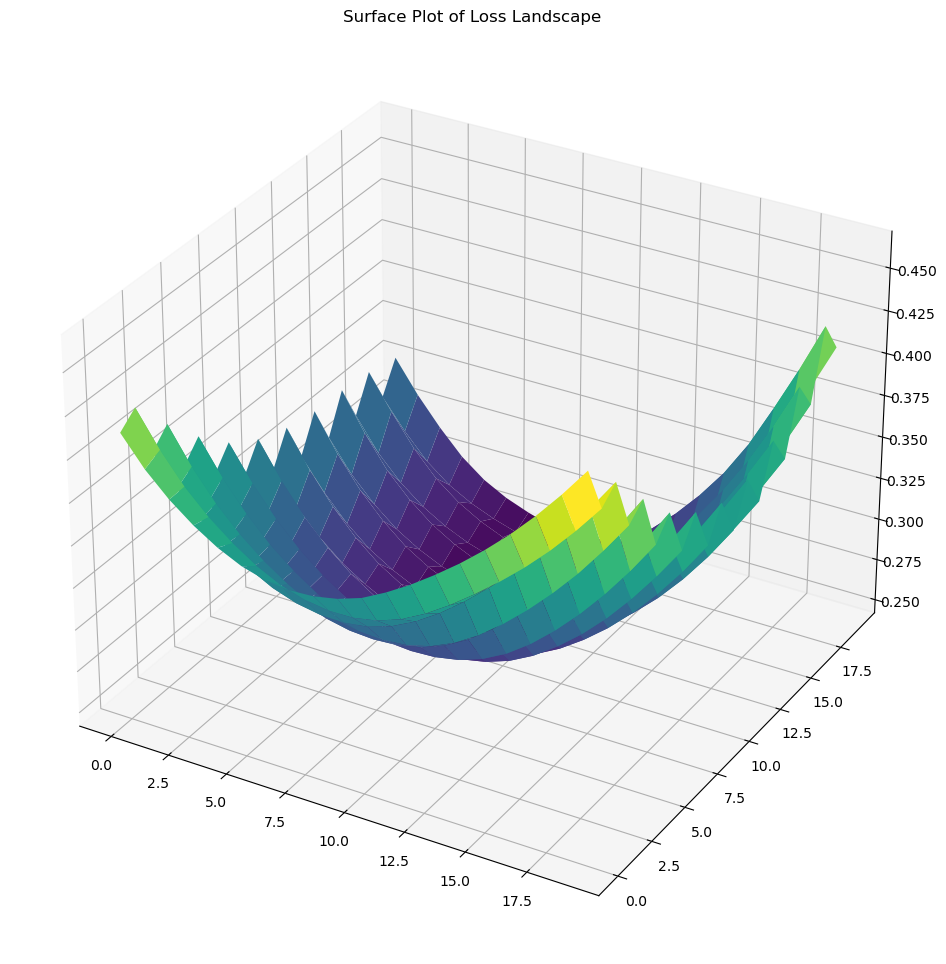

In [43]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [44]:
with open('pyhessian-unet-no-crf-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_unet)

## 5. 4 - 3

In [45]:
loss_data_diff = loss_data_fin - loss_data_unet

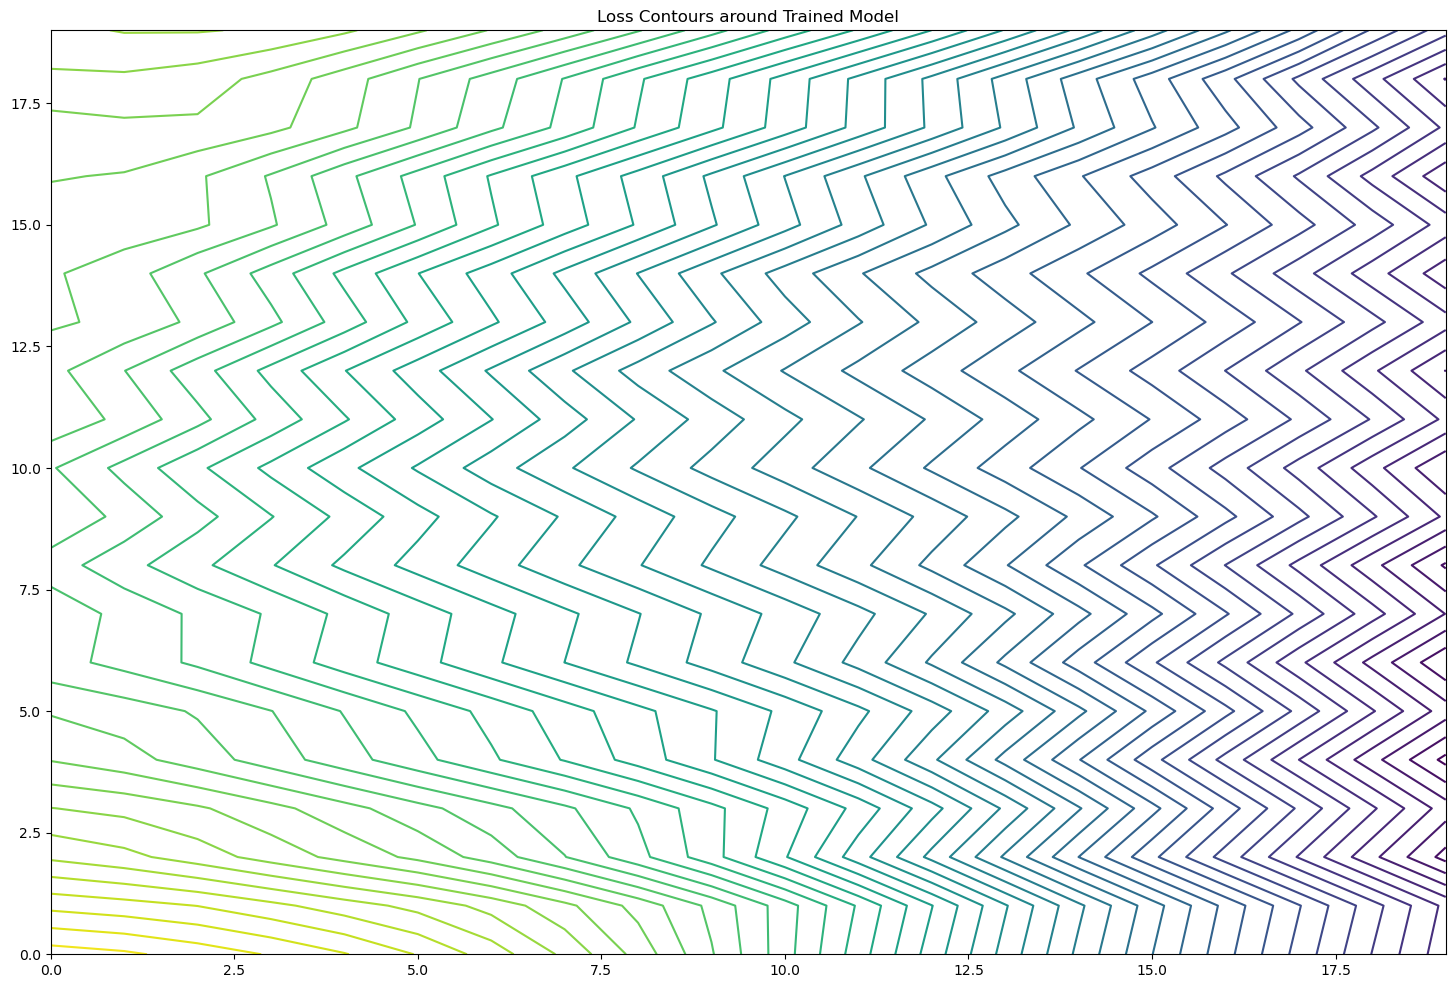

In [46]:
plt.contour(loss_data_diff, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

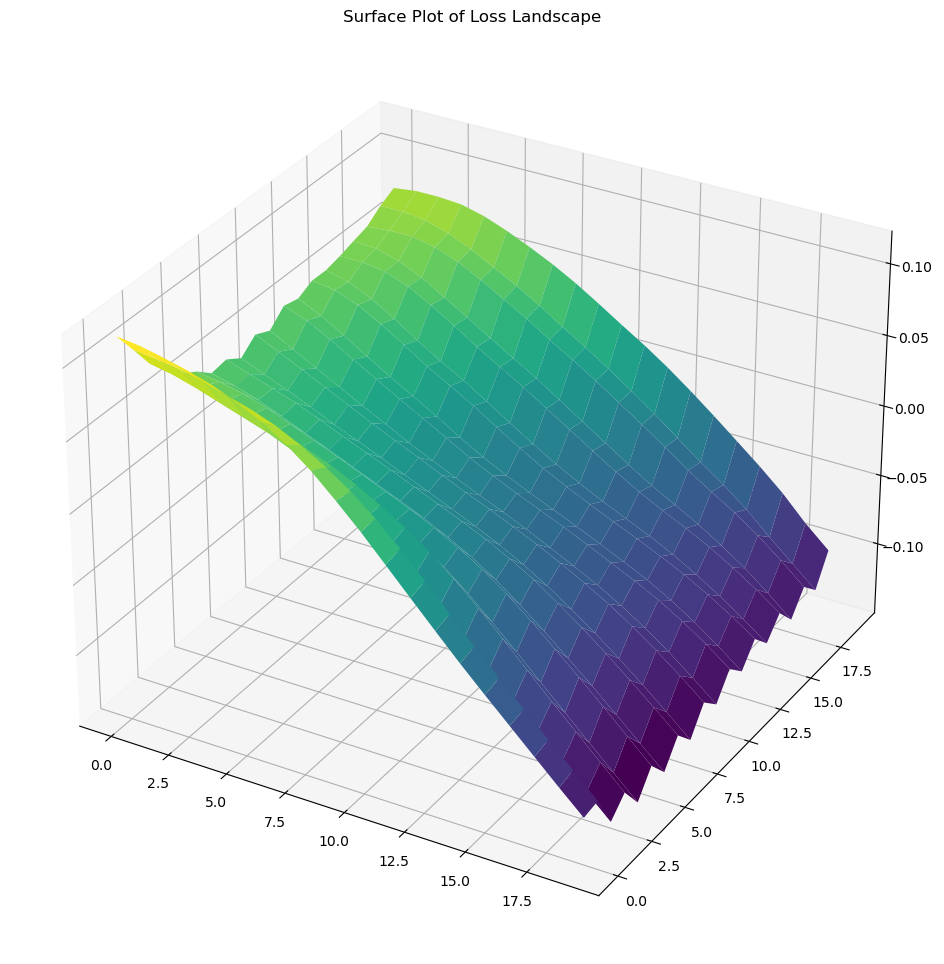

In [47]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_diff, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

## 6. Perturb CRF Only

### 6.1 PyHessian Directions and Spectrum

In [48]:
hessian_comp = hessian(crf_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [49]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 2.3508


In [50]:
density_eigen, density_weight = hessian_comp.density()

In [51]:
density, grids = density_generate(density_eigen, density_weight)

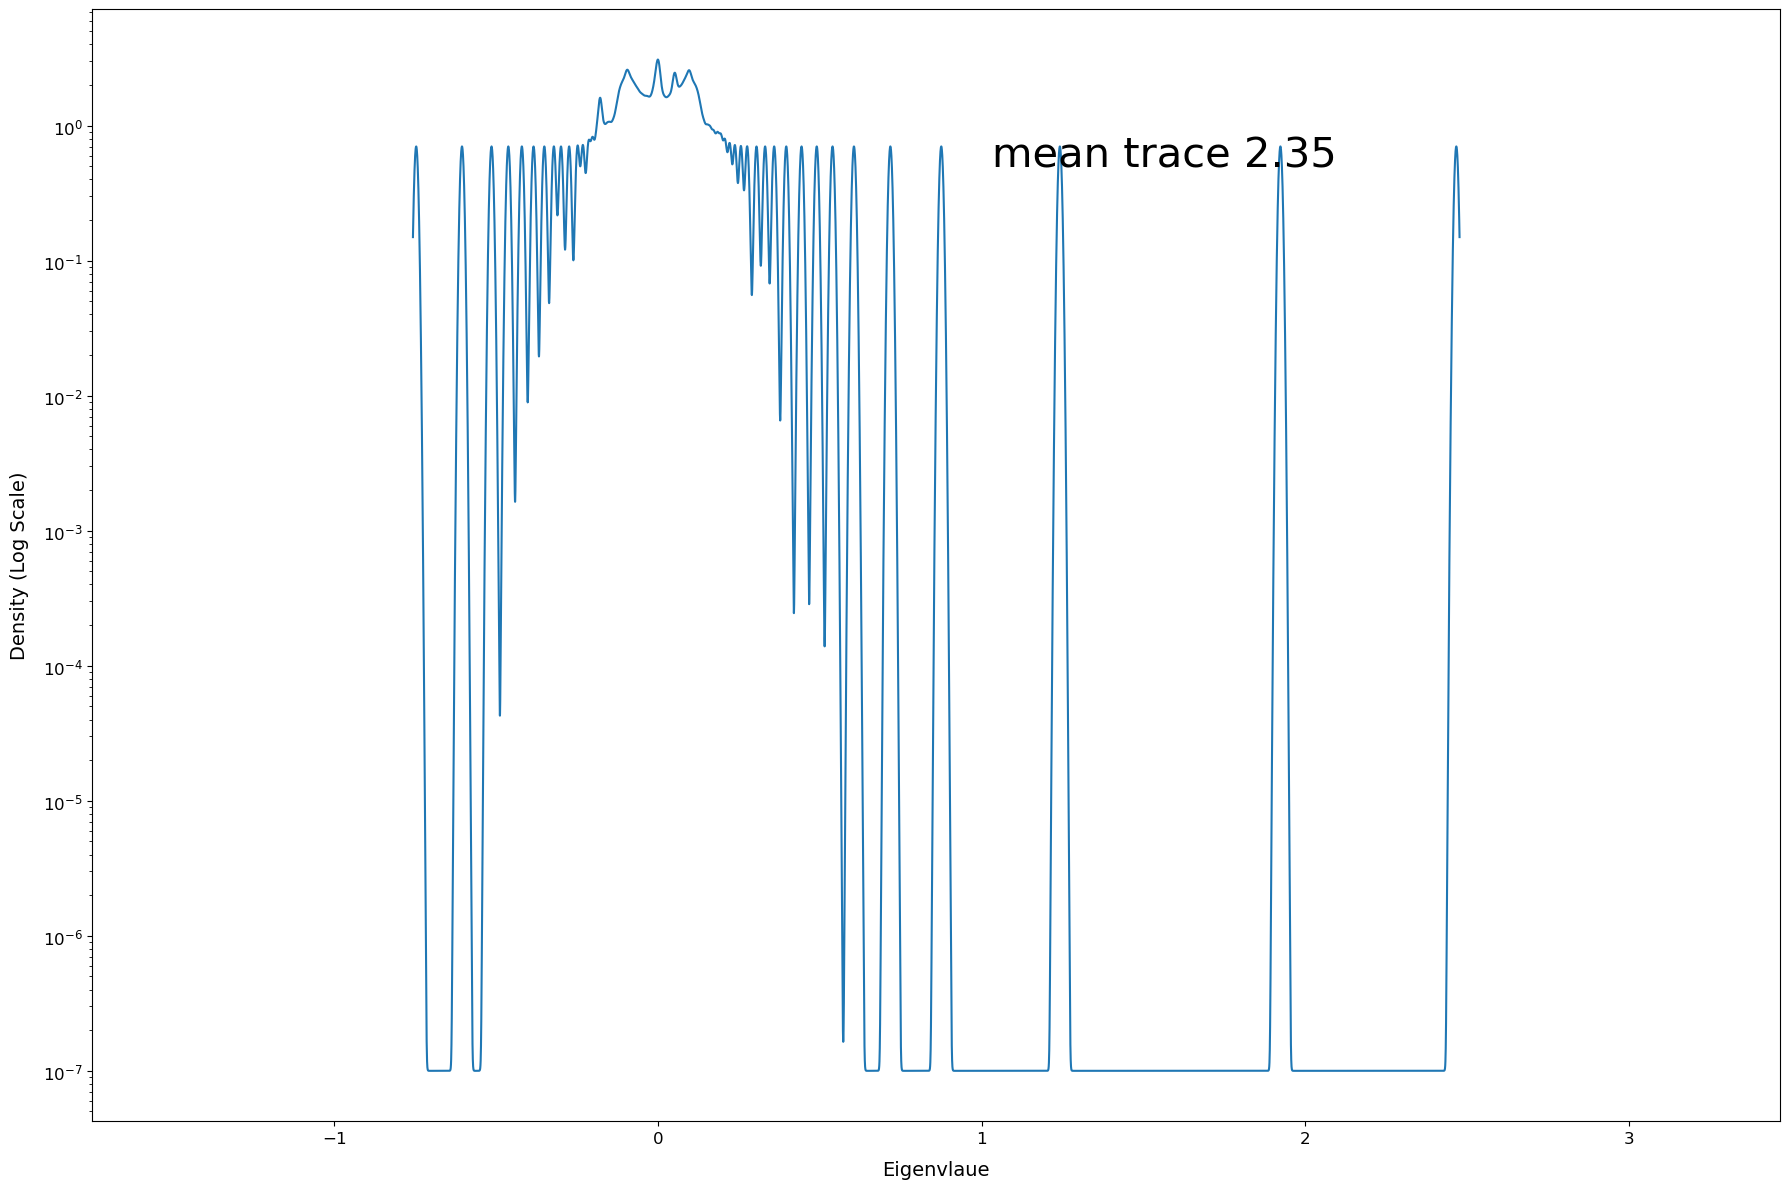

In [52]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 6.2. 2D Loss Landscape by PyHessian Directions

In [53]:
class CRFPerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, backbone, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        self.backbone.eval()
        with torch.no_grad():
            intermediate = self.backbone.forward(self.inputs)
        return self.loss_fn(model_wrapper.forward(intermediate), self.target).item()

In [54]:
crf_metric = CRFPerturbLoss(unet_final, criterion, x.to(device), y.to(device))

In [55]:
# compute loss data
pll_crf_only = loss_landscapes.PlanarLossLandscape(crf_final, STEPS, deepcopy_model=True)
pll_crf_only.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_crf_only.stats_initializer()

In [56]:
# single batch loss landscape
since = time.time()
pll_crf_only.warm_up(crf_metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_crf_only = pll_crf_only.compute(crf_metric)
print('compute time cost ', time.time()-since)

warmup time cost  184.52039313316345
compute time cost  44.0174446105957


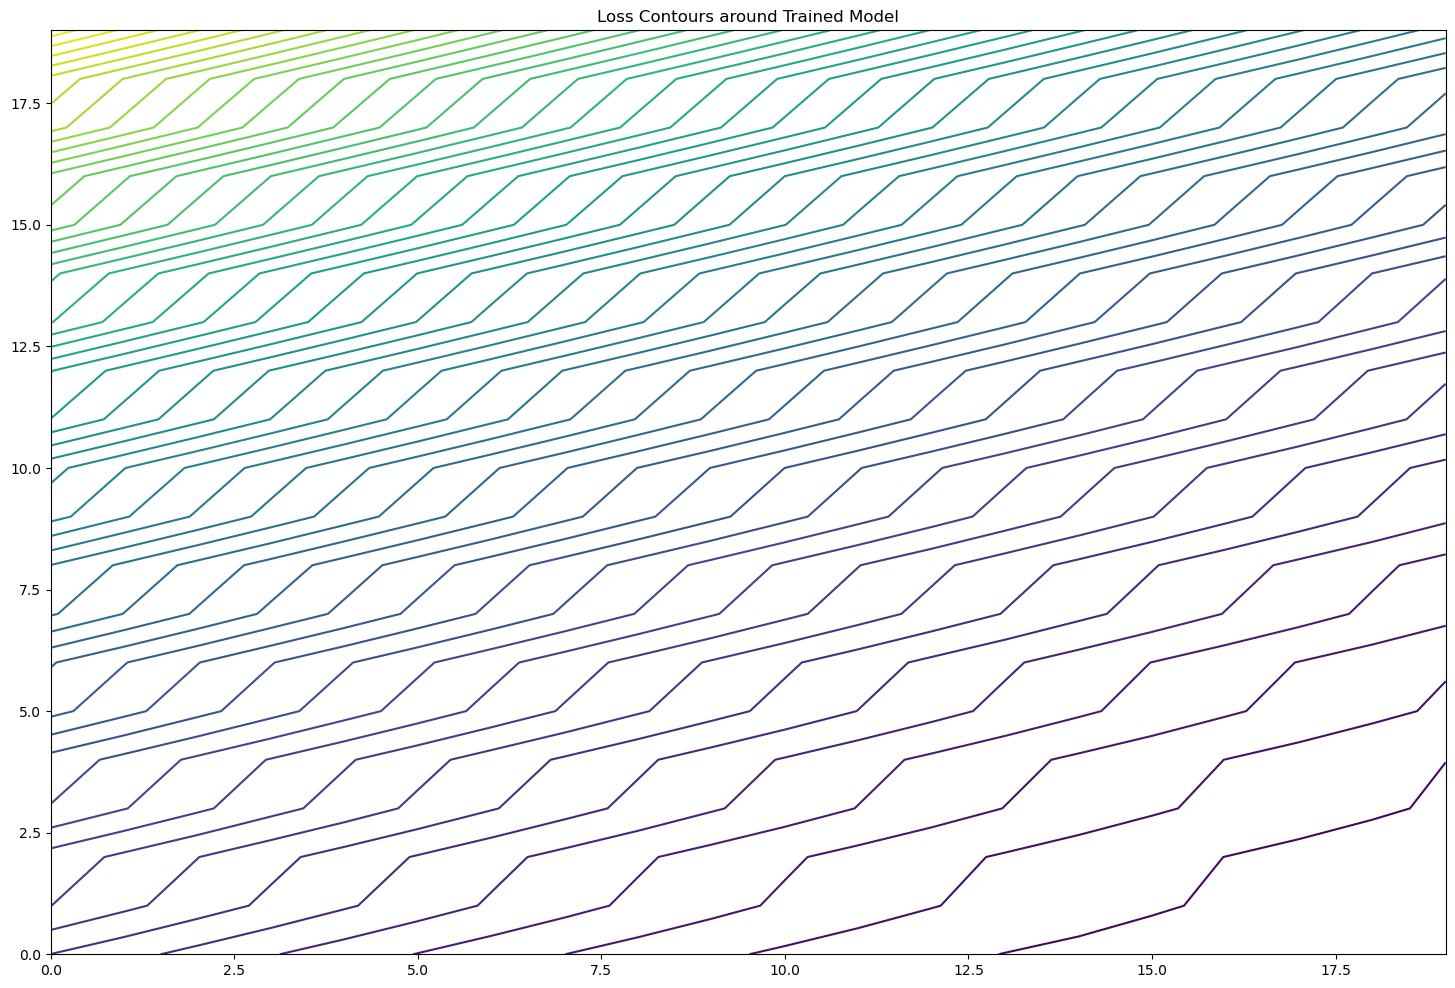

In [57]:
plt.contour(loss_data_crf_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

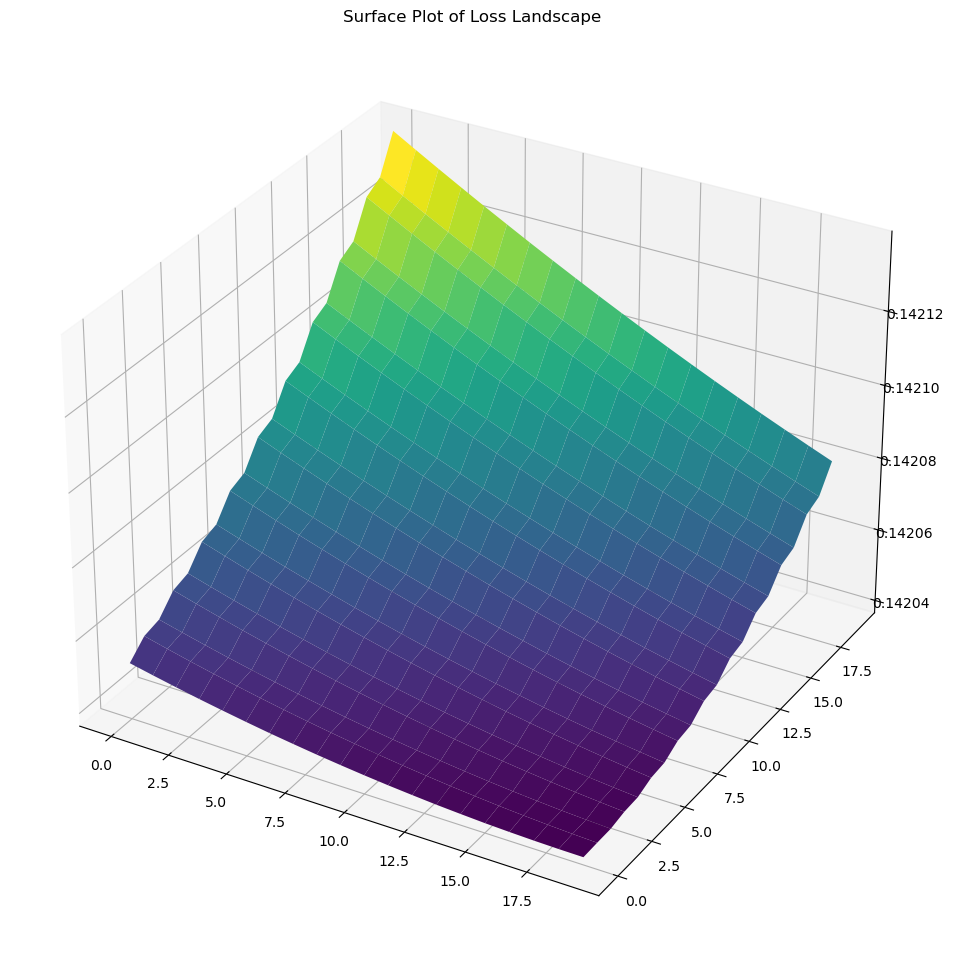

In [58]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_crf_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [59]:
with open('pyhessian-unet-crf-only-crf-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_crf_only)

## 7. Perturb UNet Only

### 7.1 PyHessian Directions and Spectrum

In [60]:
hessian_comp = hessian(unet_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [61]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 313.1990


In [62]:
density_eigen, density_weight = hessian_comp.density()

In [63]:
density, grids = density_generate(density_eigen, density_weight)

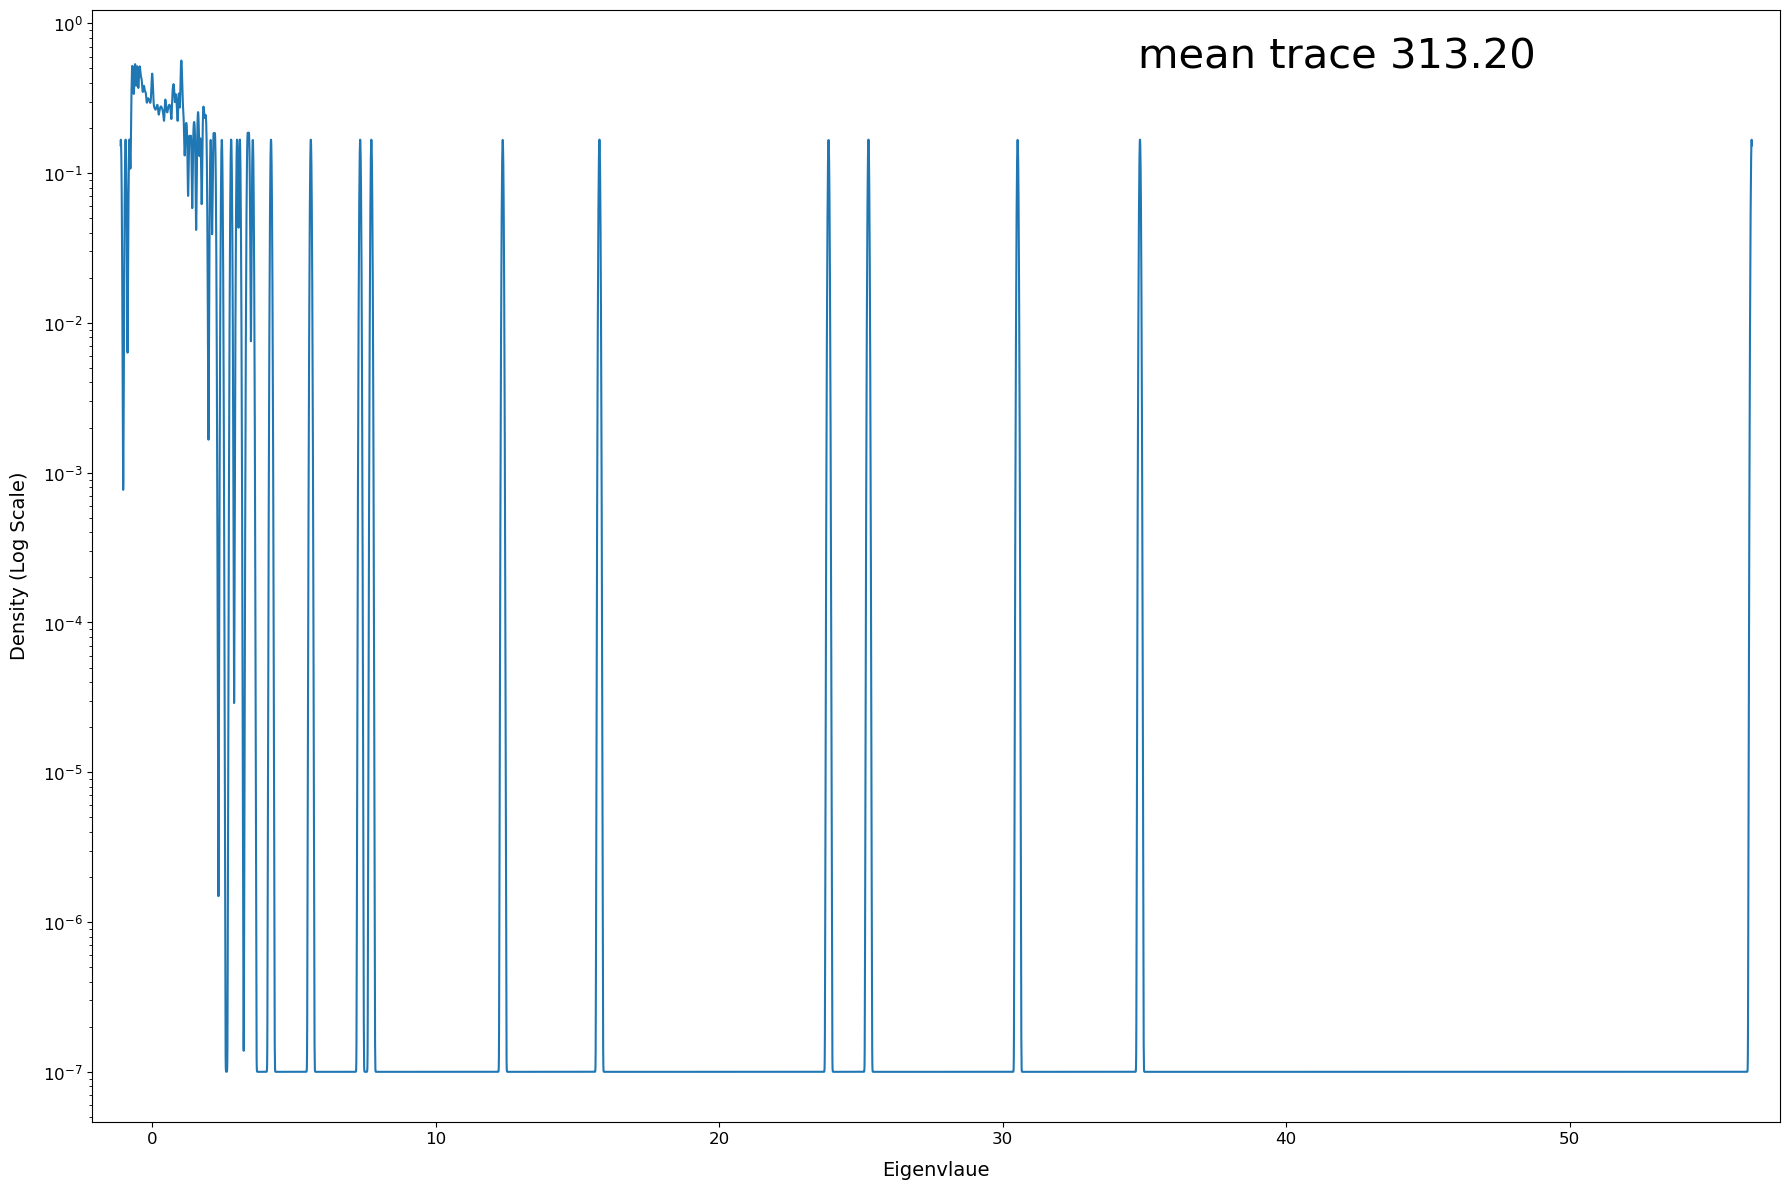

In [64]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.text(
        (np.max(density_eigen)+1)*0.85,
        1 - 0.5,
        ("mean trace %.2f" % np.mean(trace)).lstrip("0"),
        size=30,
        horizontalalignment="right",
    )
plt.tight_layout()
plt.show()

### 7.2. 2D Loss Landscape by PyHessian Directions

In [65]:
class BackbonePerturbLoss(Metric):
    """ Computes a specified loss function over specified input-output pairs, using a backbone network and only perturb CRF."""
    def __init__(self, crf, loss_fn, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.crf = crf
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        intermediate = model_wrapper.forward(self.inputs)
        self.crf.eval()
        with torch.no_grad():
            loss = self.loss_fn(self.crf.forward(intermediate), self.target).item()
        return loss

In [66]:
unet_metric = BackbonePerturbLoss(crf_final, criterion, x.to(device), y.to(device))

In [67]:
# compute loss data
pll_unet_only = loss_landscapes.PlanarLossLandscape(unet_final, STEPS, deepcopy_model=True)
pll_unet_only.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll_unet_only.stats_initializer()

In [68]:
# single batch loss landscape
since = time.time()
pll_unet_only.warm_up(unet_metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_unet_only = pll_unet_only.compute(unet_metric)
print('compute time cost ', time.time()-since)

warmup time cost  46.24828886985779
compute time cost  44.080195903778076


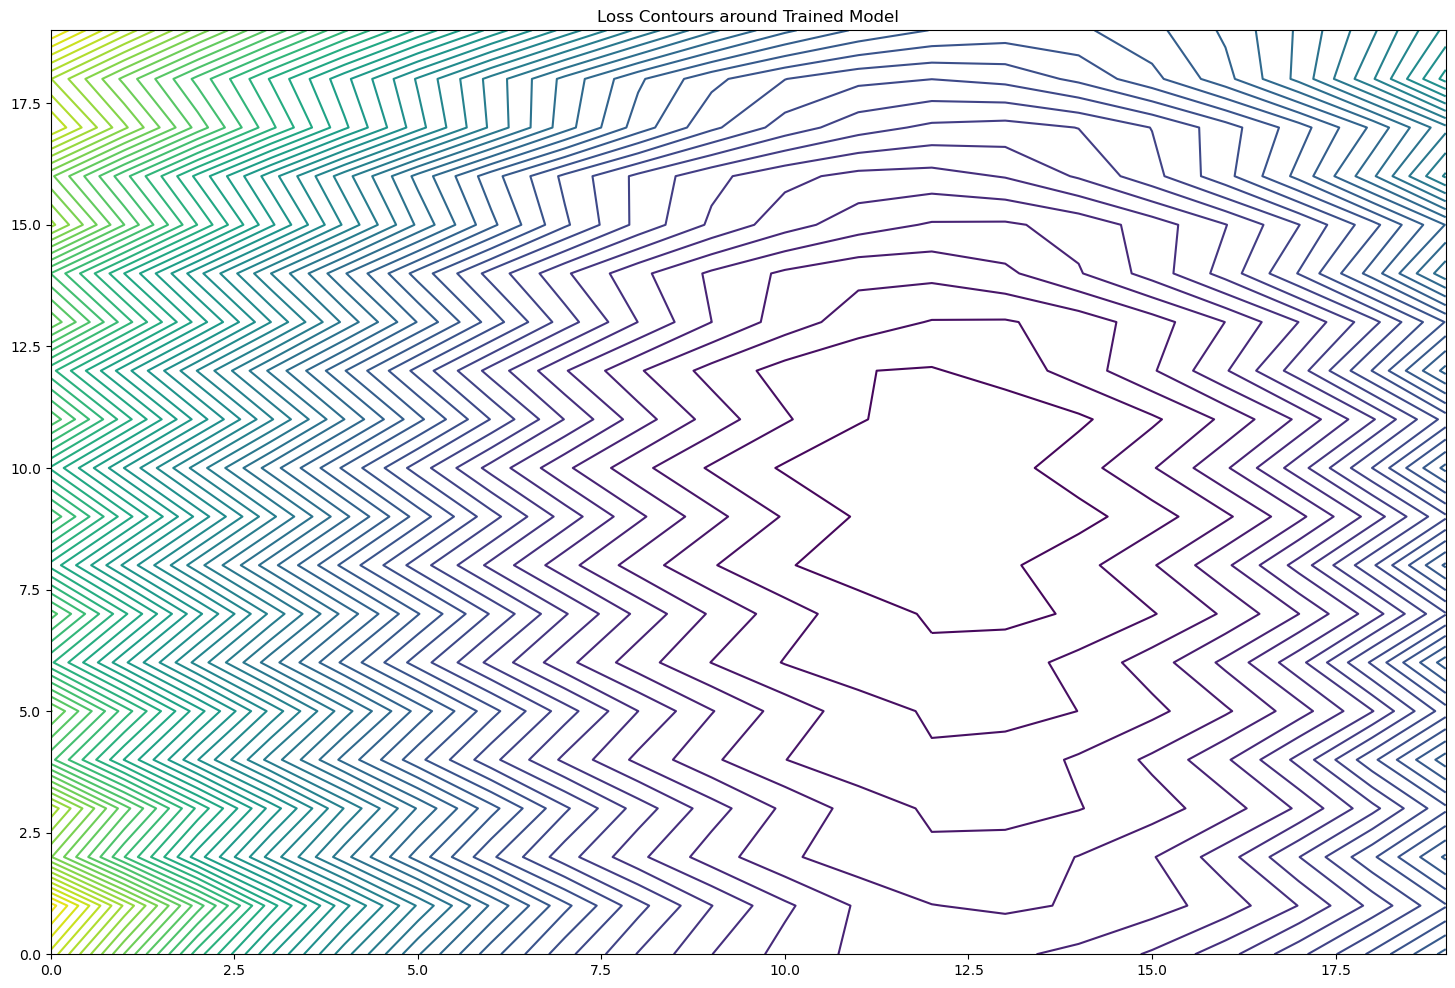

In [69]:
plt.contour(loss_data_unet_only, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

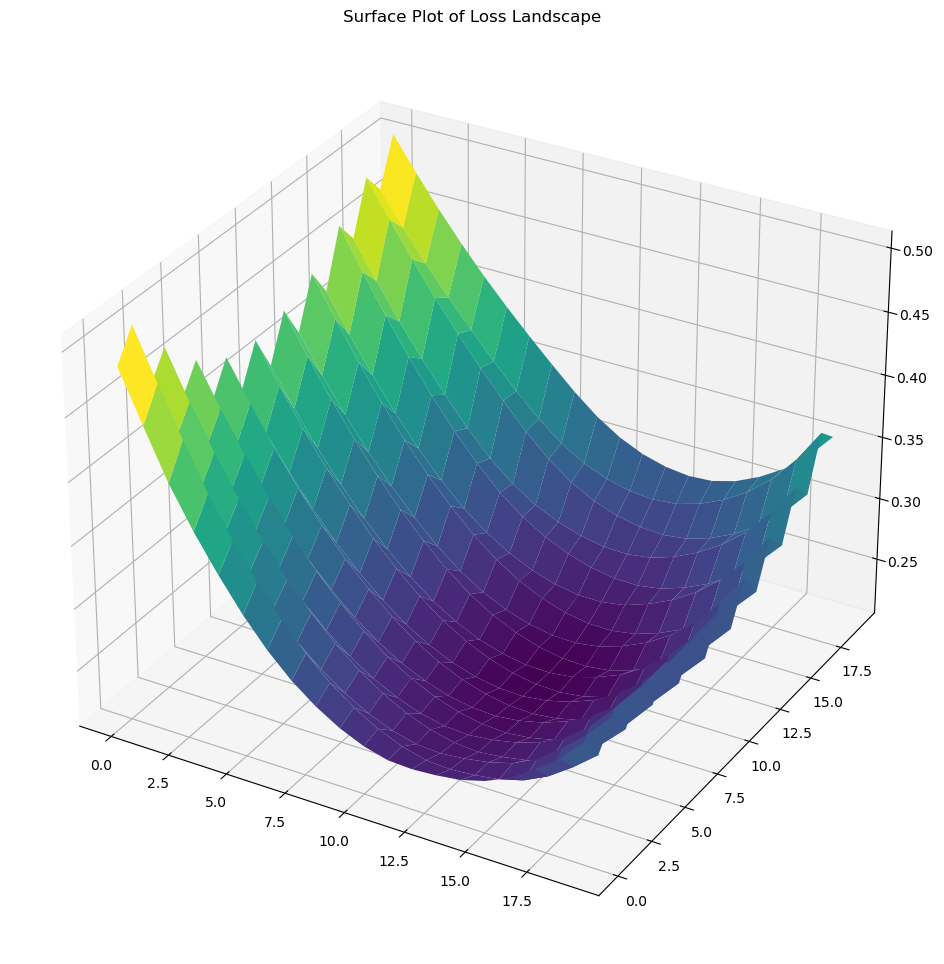

In [70]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_unet_only, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [71]:
with open('pyhessian-unet-crf-only-unet-loss-landscape.npy', 'wb') as f:
    np.save(f, loss_data_unet_only)